In [1]:
# usings
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Printf
using PyPlot

# utility functions
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

  Activating project at `~/Projects/ASTRAL/mast`


permutedims (generic function with 13 methods)

In [2]:
include("readers.jl")
using .NoaaDas
using .DasGps

In [3]:
"general PSL DAS readers"
#=
module NoaaDas

export get_das_filenames
export yday, psldatetime, decimal_hour
export read_das_dict

# utility functions
m2n(x) = ismissing(x) ? NaN : x
pd = permutedims

# parameters for ASTRAL - feed defaults to functions
baseyear = 2024
mastdir = "./data/PSL/"
# ncolumn = 22 # change for different file types

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))
yday(ddd::AbstractString) = parse(Int, ddd)

"return all filenames with prefix and date dt"
function get_das_filenames(prefix, yd::Integer, mastdir=mastdir)
    filter(startswith(prefix), 
           readdir(joinpath(mastdir, @sprintf("%03d",yd))))
end
function get_das_filenames(prefix, dt::Date, mastdir=mastdir)
    get_das_filenames(prefix, yday(dt), mastdir)
end
"return filenames with prefix matching hour of dt"
function get_das_filenames(prefix, dt::DateTime, mastdir=mastdir)
    hh = @sprintf("%02d", Dates.value(Hour(dt)))
    filter( endswith(hh*"_raw.txt"),
            get_das_filenames(prefix, Date(dt), mastdir) )
end

"return vector of full paths of all files with prefix and date"
function get_das_pathfiles(prefix, dt, mastdir=mastdir)
    joinpath.(mastdir,
              @sprintf("%03d",yday(dt)),
              get_das_filenames(prefix, dt, mastdir))
end

"Convert a PSL date to a DateTime."
function psldatetime(d::Date, hr::Integer, psltime::AbstractString)
    mm  = Minute(     parse(Int32, psltime[1:2]))
    SS  = Second(     parse(Int32, psltime[3:4]))
    sss = Millisecond(parse(Int32, psltime[5:7]))
    DateTime(Date(d)) + Hour(hr) + mm + SS + sss
end
function psldatetime(d::Date, hr::Integer=0, minute::Real=0)
    DateTime(Date(d)) + Hour(hr) + Minute(minute) + Second(second)
end
function psldatetime(yearday::Integer, hr::Integer=0; minute::Real=0, baseyear=baseyear)
    DateTime(baseyear-1,12,31) + Day(yearday) + Hour(hr) + Minute(minute)
end
# psldatetime(Date(2024,5,8), hr, "0606111")
# To get filename from the date, hour
# psldatefile(prefix, psldatetime(d, hr, psltime))

# file format default parameters
nheader = 1
# dt = DateTime(2024,5,8,11,0,0)
# pathfilename = get_das_pathfiles(prefix, dt::DateTime, mastdir=mastdir)

"read das data and put in a dictionary"
function read_das_dict(pathfilename, keys;
    nheader=nheader,
    nsample=sum(countlines.(pathfilename) .- nheader),
    ncolumn=length(keys)-1 ) # default columns in data excluding datestamp

    # read data from file
    datatime, X = read_das_data(pathfilename; 
        nheader=nheader,
        nsample=nsample,
        ncolumn=ncolumn ) # specifying manages memory best
    
    return das_dict(keys, datatime, X) # returns dict
end

parseblank2missing(T, s) = isempty(s) ? missing : parse(T, s)

"read and parse one das data file"
function read_das_data(pathfilename::AbstractString;
    nheader=1,
    nsample=countlines(pathfilenames) - nheader, 
    ncolumn=30 )

    # trivially iterate over 1-vector
    dt, X = read_scs_data(pathfilename[1:1]; 
        nheader=nheader, nsample=nsample, ncolumn=ncolumn )
    return dt, X
end

"read and concatenate data from multiple files"
function read_das_data(pathfilename::Vector{<:AbstractString};
    nheader=1,
    nsample=sum( countlines.(pathfilenames) - nheader ),
    ncolumn=30 ) # data, not including timestamp

    # preallocate the data
    # psltime = Vector{String}(undef, nsample) # will point to data as it is read
    psldt = Vector{DateTime}(undef, nsample) # will point to data as it is read
    X = Array{Union{Float32,Missing}, 2}(undef, nsample, ncolumn)
    fill!(X, missing)

    nl = 0
    maxcol=0
    for pfile in pathfilename
        # find hour from the filename
        shortfilename = last(splitpath(pfile))
        ddd = shortfilename[end-12:end-10]
        basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
        hr = parse(Int32, shortfilename[end-9:end-8])

        open(pfile) do file
            for _ in 1:nheader
                readline(file) # skip header
            end
            for line in readlines(file)
                nl += 1
                splt = split(line, r"[\s,]+")

                nx = min(ncolumn, length(splt[2:end]))
                if nx > 0 # skip empty lines
                    psltime = splt[1]
                    psldt[nl] = psldatetime(basedt, hr, psltime)

                    dataline = try
                        parseblank2missing.(Float32, splt[2:end])
                    catch
                        error("failed to parse: $(splt[2:end])")
                    end
                    maxcol = max(maxcol, nx) # data in longest line
                    X[nl, 1:nx] .= dataline[1:nx]
                end
            end
        end
    end

    return psldt[1:nl], X[1:nl, 1:maxcol]
end

"assign data to a dict of keys"
function das_dict(keys, datatime, X)
    D = Dict{eltype(keys), Any}()

    # special DateTime
    D[keys[1]] = datatime 
    # fill rest of dictionary
    for (ik, ky) in enumerate(keys[2:end])
        D[ky] = X[:, ik]
    end
    return D
end

"compute the decimal hour of day from a datetime"
function decimal_hour(dt::DateTime)::Float64
    hour = Dates.hour(dt)
    minute = Dates.minute(dt)
    second = Dates.second(dt)
    millisecond = Dates.millisecond(dt)
    
    # Calculate the decimal hour
    decimal_hour = hour + minute / 60 + second / 3600 + millisecond / 3600000
    return decimal_hour
end
=#

"general PSL DAS readers"

In [4]:
# GPS readers module DasGps now in readers.jl

#=
# module DasGps

# using Dates
# using ..NoaaDas

# export read_gps_dict, read_hed_dict

# parameters for ASTRAL - feed defaults to functions
baseyear = 2024
mastdir = "./data/PSL/"

"yearday from Date or DateTime"
yday(dt) = Dates.value(Date(dt) - Date(year(dt)-1,12,31))
yday(ddd::AbstractString) = parse(Int, ddd)

"read gps file GPRMC data into a dict"
function read_gps_dict(pathfilename;
    nheader=1,
    nsample=countlines(pathfilename) - nheader,
    ncolumn=7 )

    # find datetime from the filename
    shortfilename = last(splitpath(pathfilename))
    ddd = shortfilename[end-12:end-10]
    basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
    hr = parse(Int32, shortfilename[end-9:end-8])
    # method: psldatetime(d::Date, hr::Integer, psltime::String)

    # preallocate the data
    psldt  = Vector{DateTime}(undef, nsample) # will point to data as it is read
    gpsdt  = Vector{DateTime}(undef, nsample) # will point to data as it is read
    lat    = Vector{Float64}(undef, nsample)
    lon    = Vector{Float64}(undef, nsample)
    speed  = Vector{Float64}(undef, nsample)
    course = Vector{Float64}(undef, nsample)

    nl=0
    open(pathfilename) do file
        for _ in 1:nheader
            readline(file) # skip header
        end
        for line in readlines(file)
            fields = split(line, [' ','\t'])
            if startswith(fields[2], "\$GPRMC")
                nl += 1
                psltime = fields[1] # string
                psldt[nl] = psldatetime(Date(basedt), hr, psltime)
                gpsdt[nl], lat[nl], lon[nl], speed[nl], course[nl] = parse_gprmc(fields[2])
            end
        end
    end

    # Return a dictionary with the parsed fields
    D = Dict{Symbol, Any}()
    # DateTime
    D[:time]     = psldt[1:nl]
    D[:gpstime]  = gpsdt[1:nl]
    # Float
    D[:lat]      = lat[1:nl]
    D[:lon]      = lon[1:nl]
    D[:sog_kts]  = speed[1:nl]
    D[:cog_deg]  = course[1:nl]

    return D
end

"""
Parse one GPRMC NMEA message.

Arguments:
- `message::String`: GPRMC NMEA message

Returns:
- A dictionary containing the parsed fields
"""
function parse_gprmc(message::AbstractString)
    # Split the message into fields
    fields = split(message, ",")
    
    # Check that the message is a GPRMC message
    # and position is valid.
    if fields[1] != "\$GPRMC"
        error("Not a GPRMC message")
    elseif fields[3] != "A"
        error("Invalid position status")
    end
    
    # Extract the fields
    time_str = fields[2]
    # status = fields[3]
    lat_str = fields[4]
    lat_dir = fields[5]
    lon_str = fields[6]
    lon_dir = fields[7]
    speed_str = fields[8]
    course_str = fields[9]
    date_str = fields[10]
    
    # Parse the time (hhmmss.sss) and date (ddmmyy)
    time = tryparse(Time, time_str[1:6], dateformat"HHMMSS")
    date = tryparse(Date, date_str, dateformat"ddmmyy")

    # Combine date and time into a DateTime object
    gpstime = try 
        DateTime(date, time) 
    catch 
        @warn "Invalid date or time format"
    end

    # Parse latitude and longitude in degrees and minutes (ddmm.mmmm)
    lat_deg = tryparse(Float64, lat_str[1:2])
    lat_min = tryparse(Float64, lat_str[3:end])
    lat = lat_deg + lat_min / 60
    if lat_dir == "S"
        lat = -lat
    end

    lon_deg = tryparse(Float64, lon_str[1:3])
    lon_min = tryparse(Float64, lon_str[4:end])
    lon = lon_deg + lon_min / 60
    if lon_dir == "W"
        lon = -lon
    end

    # Parse speed (knots) and course (degrees)
    speed = tryparse(Float64, speed_str)
    course = tryparse(Float64, course_str)

    # Return a dictionary with the parsed fields
    return gpstime, lat, lon, speed, course
end
# Example usage
# message = "\$GPRMC,123519,A,4807.038,N,01131.000,E,022.4,084.4,230394,003.1,W*6A"
# parsed_data = parse_gprmc(message)
# println(parsed_data)

"read differential gps heading data into a dict"
function read_hed_dict(pathfilename;
    nheader=1,
    nsample=countlines(pathfilename) - nheader,
    ncolumn=2 )

    # find datetime from the filename
    shortfilename = last(splitpath(pathfilename))
    ddd = shortfilename[end-12:end-10]
    basedt = Date(baseyear-1,12,31) + Day(yday(ddd))
    hr = parse(Int32, shortfilename[end-9:end-8])
    # method: psldatetime(d::Date, hr::Integer, psltime::String)

    # preallocate the data
    psldt   = Vector{DateTime}(undef, nsample) # will point to data as it is read
    heading = Vector{Float32}(undef, nsample)
    roll    = Vector{Float32}(undef, nsample)

    nl=0
    open(pathfilename) do file
        for _ in 1:nheader
            readline(file) # skip header
        end
        for line in readlines(file)
            fields = split(line, [' ','\t'])
            if startswith(fields[2], "\$PSAT,HPR")
                nl += 1
                psltime = fields[1] # string
                psldt[nl] = psldatetime(Date(basedt), hr, psltime)
                heading[nl], roll[nl] = parse_hpr(fields[2])
            end
        end
    end

    # Return a dictionary with the parsed fields
    D = Dict{Symbol, Any}()
    D[:time]     = psldt[1:nl]    # DateTime
    D[:heading]  = heading[1:nl]    # Float
    D[:roll]     = roll[1:nl]
    return D
end

"""
Parse a PSAT,HPR NMEA message of the form
\$PSAT,HPR,000002.00,184.19,,-1.73,N*3D

Arguments:  message::String`: PSAT,HPR NMEA message
Returns:    heading::Float32, roll::Float:32
"""
function parse_hpr(message::AbstractString)
    # example
    # $PSAT,HPR,000002.00,184.19,,-1.73,N*3D

    # Split the message into fields
    fields = split(message, ",")
    
    # Check that the message is a PSAT message
    if !startswith(fields[1], "\$PSAT") || !startswith(fields[2], "HPR")
        error("Not a $PSAT,HPR message")
    end

    # Parse heading and roll
    heading_deg = tryparse(Float32, fields[4])
    roll_deg    = tryparse(Float32, fields[6])
    
    # Return a dictionary with the parsed fields
    return heading_deg, roll_deg
end

# end # DasGps
=#

In [6]:
# read example
baseyear = 2024
mastdir = "./data/PSL"
dt = DateTime(2024,5,8)
pathfilename = get_das_pathfiles("gps", dt, mastdir)[1]
Gps = read_gps_dict(pathfilename)

Dict{Symbol, Any} with 6 entries:
  :gpstime => [DateTime("0024-05-08T00:00:00"), DateTime("0024-05-08T00:00:01")…
  :cog_deg => [201.37, 201.05, 199.71, 199.29, 198.64, 195.9, 195.06, 194.66, 1…
  :sog_kts => [8.14, 8.28, 8.39, 8.44, 8.26, 8.53, 8.23, 8.6, 8.44, 8.32  …  0.…
  :lat     => [3.34709, 3.34708, 3.34707, 3.34706, 3.34706, 3.34705, 3.34704, 3…
  :lon     => [84.6788, 84.6788, 84.6787, 84.6787, 84.6787, 84.6787, 84.6787, 8…
  :time    => [DateTime("2024-05-08T00:00:00.054"), DateTime("2024-05-08T00:00:…

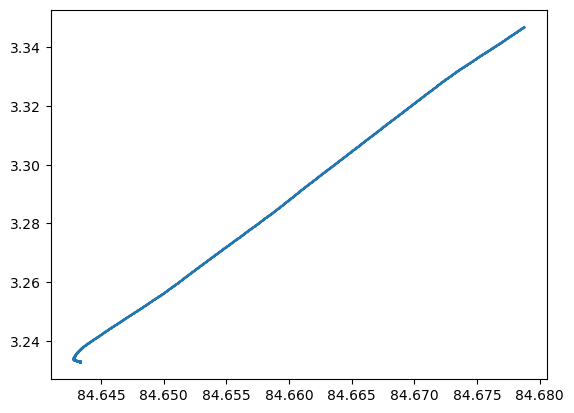

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x31b2f83a0>

In [7]:
plot(Gps[:lon],Gps[:lat], marker=".", markersize=0.1, linewidth=0.25)

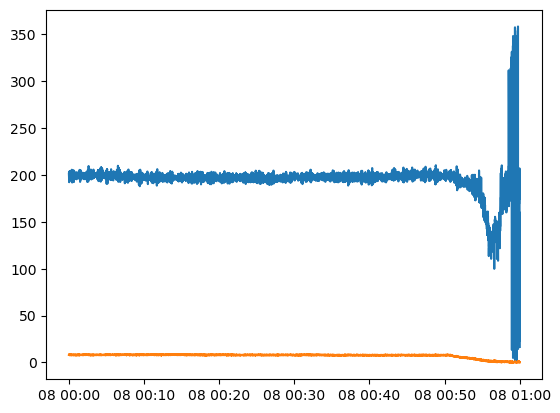

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x320198dc0>

In [8]:
plot(Gps[:time], Gps[:cog_deg])
plot(Gps[:time], Gps[:sog_kts])

In [9]:
mastdir = "./data/PSL"
dt = DateTime(2024,5,8)
pathfilename = get_das_pathfiles("hed", dt, mastdir)[1]
Hed = read_hed_dict(pathfilename)

Dict{Symbol, Any} with 3 entries:
  :roll    => Float32[-2.39, -2.33, -1.42, -0.03, 0.52, -0.36, -0.88, -2.31, -2…
  :heading => Float32[212.88, 212.46, 212.19, 212.43, 212.26, 212.06, 212.17, 2…
  :time    => [DateTime("2024-05-08T00:00:00.275"), DateTime("2024-05-08T00:00:…

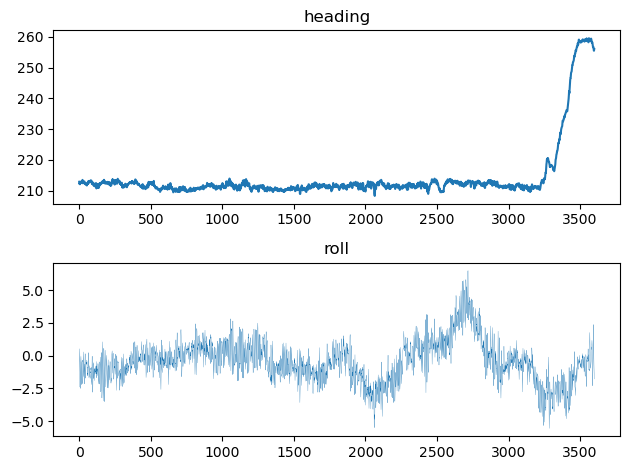

In [10]:
subplot(2,1,1)
plot(Hed[:heading]); title("heading")
subplot(2,1,2)
plot(Hed[:roll], linewidth=0.2); title("roll")
tight_layout()